# Chapter 21: Space Invaders with Double Deep Q-Learning






New Skills in This Chapter:

• Playing Space Invaders with and without the Baselines game wrapper

• Modifying an existing Q-network to apply to Space Invaders

• Playing Space Invaders with the trained double Q-network

• Capturing time steps that the agent eliminates all invaders

***
*We demonstrate that the deep Q-network agent, receiving only the pixels and the game score as inputs, was able to surpass the performance of all previous algorithms and achieve a level comparable to that of a professional human games tester across a set of 49 games, using the same algorithm, network architecture and hyperparameters.*<br>
***
Human-level control through deep reinforcement learning

--Mnih et al, 2015, Nature

***

In [1]:
import os

os.makedirs("files/ch21", exist_ok=True)

# 21.1. Get Started with the Space Invaders Game

## 21.1.1. The Space Invaders Game in OpenAI Gym

In [2]:
import gym

env = gym.make("SpaceInvaders-v0")
env.reset()
env.render()

True

In [3]:
# Action space
action_space = env.action_space
print(f"The action space for Space Invaders is {action_space}")
# Meanings of the actions
meanings = env.env.get_action_meanings()
print(f"The meanings of the actions are\n {meanings}")
# Print out the observation space in this game
obs_space = env.observation_space
print(f"The observation space is {obs_space}")

The action space for Space Invaders is Discrete(6)
The meanings of the actions are
 ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
The observation space is Box(210, 160, 3)


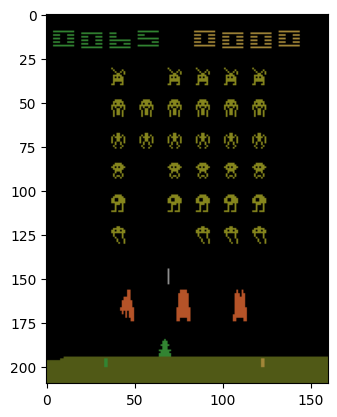

In [4]:
import matplotlib.pyplot as plt
import numpy as np

env.reset()
num_actions = env.action_space.n
for _ in range(200):
    action = np.random.choice(num_actions)
    obs, reward, done, info = env.step(action)
plt.imshow(obs)
plt.show()
env.close()

In [5]:
from pprint import pprint

env.reset()
history = []
while True:
    action = np.random.choice(num_actions)
    obs, reward, done, info = env.step(action)
    env.render()
    history.append([reward, done, info])
    if info["ale.lives"]==2:     
        break  
env.close()    
pprint(history[-10:])        

[[0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 2}]]


## 21.1.2. Space Invaders with the Baselines Game Wrapper

In [6]:
from baselines.common.atari_wrappers import make_atari
from baselines.common.atari_wrappers import wrap_deepmind

# Use the Baseline Atari environment
env = make_atari("SpaceInvadersNoFrameskip-v4")
# Process and stack the frames
env = wrap_deepmind(env, frame_stack=True, scale=True)

obs = env.reset()
history = []
while True:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    history.append([reward, done, info])
    env.render()
    if done:
        break
pprint(history[-10:]) 

C:\Users\hlliu2\Anaconda3\envs\MLA\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, False, {'ale.lives': 3}],
 [0.0, True, {'ale.lives': 2}]]


As you can see, when the number of lives changes from 3 to 2, the variable done becomes True and the episode ends. Note that the reward is still 0, but we can code it as -1 by using this line of code; you'll see it in the script for training later:

```python
    # Each time the agent loses a life, set Q to -1; important
    new_Qs = Qs * (1 - dones) - dones
```

Run the following to close the game window.

In [7]:
env.close()

## 21.1.3. Game Windows from OpenAI Baselines

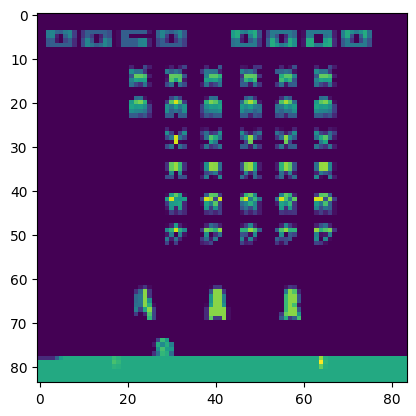

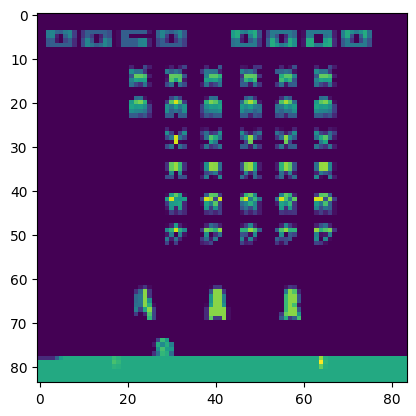

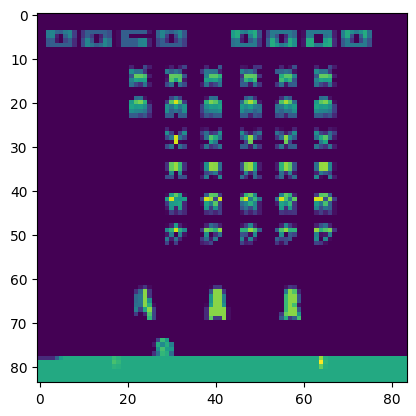

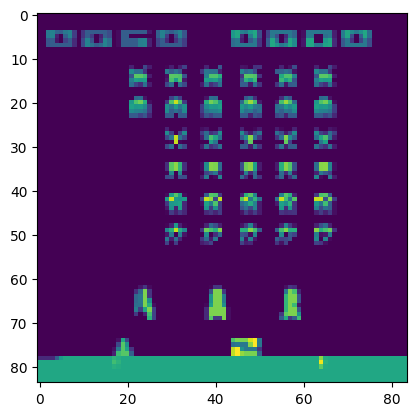

In [8]:
import matplotlib.pyplot as plt
import numpy as np

npobs=np.array(obs)
for i in range(4):
    plt.imshow(npobs[:,:,i])
    plt.show()

C:\Users\hlliu2\Anaconda3\envs\MLA\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


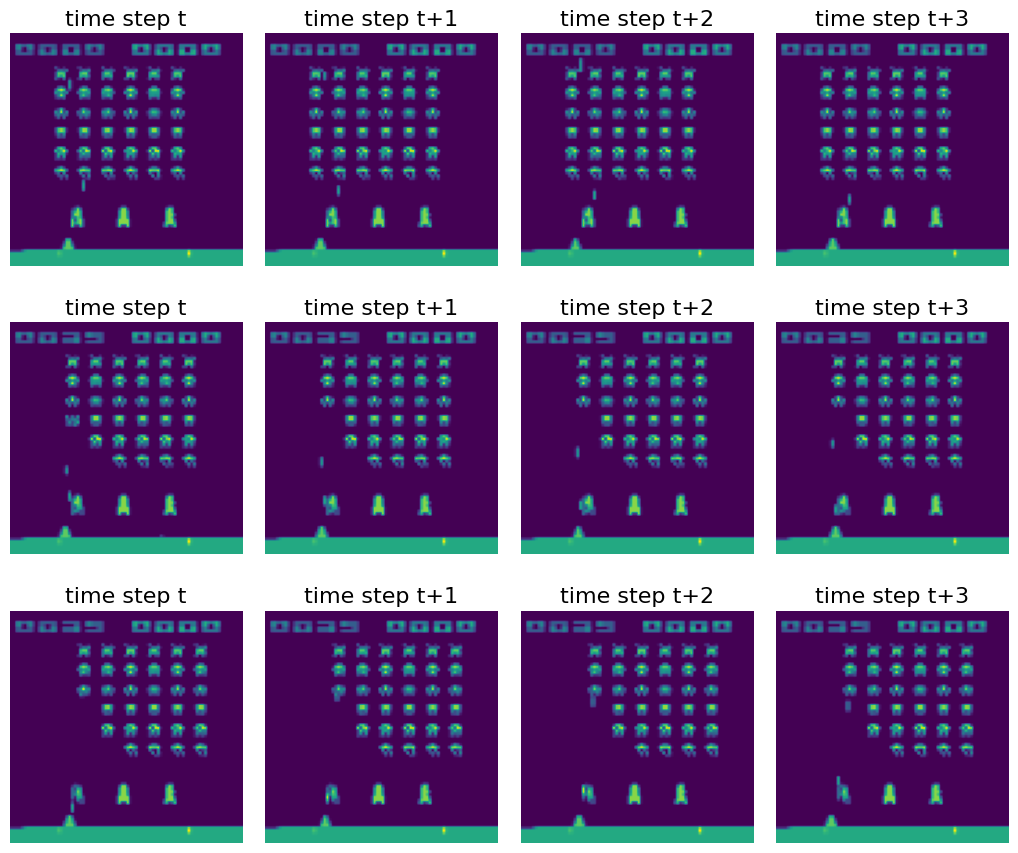

In [9]:
from utils.ch21util import invaders_windows

invaders_windows()

<img src="https://gattonweb.uky.edu/faculty/lium/ml/invaders_windows.jpg" />

# 21.2. Train the Double Deep Q-Network

## 21.2.1. The Same Double Deep Q-Network

In [10]:
num_actions = env.action_space.n

In [11]:
from tensorflow import keras

input_shape = (84, 84, 4,)
def create_model():
    model=keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=32,kernel_size=8,
         strides=(4,4), activation="relu",
         input_shape=input_shape))
    model.add(keras.layers.Conv2D(filters=64,kernel_size=4,
         strides=(2,2), activation="relu"))
    model.add(keras.layers.Conv2D(filters=64,kernel_size=3,
         strides=(1,1), activation="relu"))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation="relu"))
    model.add(keras.layers.Dense(num_actions))
    return model

In [12]:
# Network for training
dnn=create_model()
# Network for predicting (target network)
target_dnn=create_model()

In [13]:
lr=0.00025
optimizer=keras.optimizers.Adam(learning_rate=lr,clipnorm=1)
loss_function=keras.losses.Huber()

## 21.2.2. The Same Training Process

For that purpose, we create a replay buffer with a maximum length of 50,000 elements to train the deep Q-network. The replay buffer stores game histories from the agent's interaction with the environment. When training the model, we randomly select a batch of past experience to update the model weights.

In the local module ch21util, we'll use the same hyperparameters that we used in Chapter 20. We'll use these hyperparameters again for all Atari games in Chapter 22:

In [14]:
from collections import deque

# Discount factor for past rewards
gamma=0.99 
# batch size
batch_size=32  
# Create a replay buffer 
memory=deque(maxlen=50000)
# Create a running rewards list 
running_rewards=deque(maxlen=100)

Similarly, we define a function *update_Q()* in the local module to update model weights by using the output from the function *gen_batch()* we just defined. Go to the file *ch21util.py* and you'll see the exact definition of the function. It is the same as the function *update_Q()* we defined in Chapter 20, and we'll use the it again in Chapter 22 for all Atari games. 

In the local module *ch21util*, we also define a function *play_episode()* to play a full episode of the Space Invaders game. We allow a maximum of 10,000 time steps in each game. When selecting actions, the agent uses a combination of exploitatin and exploration. Specifically, in the first 50,000 frames, the agent takes random actions before using predictions from the trained Q-network to select actions. Because the model uses four consecutive game windows as inputs, model parameters are updated after every four actions. To overcome the overestimation bias in Q-learning, we update the weights in the target network after every 10,000 frames by using the weights from the training network. The function *play_episode()* defined in the local module *ch21util* is as follows, and we'll use a similar version in Chapter 22 when we generalize it to all Atari games:

In [15]:
def play_episode():
    global frame_count
    # reset state and episode reward before each episode
    state = np.array(env.reset())
    episode_reward = 0    
    # Allow 10,000 steps per episode
    for timestep in range(1, 10001):
        frame_count += 1
        # Calculate current epsilon based on frame count
        epsilon = max(0.1, 1 - frame_count * (1-0.1) /1000000)
        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or \
            epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        # Use exploitation
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = dnn(state_tensor, training=False)
            action = tf.argmax(action_probs[0]).numpy()
        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)
        episode_reward += reward
        # Change done to 1.0 or 0.0 to prevent error
        if done==True:
            done=1.0
        else:
            done=0.0
        # Save actions and states in replay buffer
        memory.append([state, state_next, action, reward, done])
        # current state becomes the next state in next round
        state = state_next
        # Update Q once batch size is over 32
        if len(memory) > batch_size and \
            frame_count % update_after_actions == 0:
            update_Q()
        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            target_dnn.set_weights(dnn.get_weights())
            # Periodically save the model
            dnn.save("files/ch21/DoubleQ_Invaders.h5")         
        if done:
            running_rewards.append(episode_reward)
            break

To train the model, we define a function *train_invaders()* in the local module *ch21util*. The function starts the training process until the average score in the past 100 games reaches at least 20. The definition of the function is as follows:

In [16]:
def train_invaders():
    global frame_count    
    episode=0
    frame_count=0
    while True: 
        episode += 1
        play_episode()
        running_reward = np.mean(np.array(running_rewards))
        if episode%20==0:
            # Log details
            m="running reward: {:.2f} at episode {} and frame {}"
            print(m.format(running_reward,episode,frame_count))
        if running_reward>20:
            dnn.save("files/ch21/DoubleQ_Invaders.h5")
            print(f"solved at episode {episode}")
            break

We then import the function *train_invaders()* from the local module and call the function to train the double deep Q-network agent in Space Invaders, like so:

In [17]:
from utils.ch21util import train_invaders

train_invaders()

The above code
cell takes two to three days to run on a regular computer. The trained model is
saved as DoubleQ_Invaders.h5 on your computer. Alternatively, you can download
the trained model from the book’s GitHub repository.

# 21.3. Test the Trained Agent in Space Invaders 

## 21.3.1. Testing One Full Original Episode

In [18]:
from utils.ch21util import invaders_episode

invaders_episode()

## 21.3.2. Average Performance of the Trained Model

We now play 100 games and turn off the graphical rendering. We'll see what is the average score. To save space, we ... 

In [19]:
from utils.ch21util import test_invaders

test_invaders()

# 21.4. Animate Space Invaders

## 21.4.1. Collect Space Invaders Episodes

In [20]:
def collect_invaders():
    frames = []
    state = env.reset()
    for i in range(3):
        episode_frames = []
        for j in range(10000):
            if np.random.rand(1)[0]<0.01:
                action = np.random.choice(4)
            else:
                state_tensor = tf.convert_to_tensor(state)
                state_tensor = tf.expand_dims(state_tensor,0)
                action_probs = reload(state_tensor,
                                      training=False)
                action = tf.argmax(action_probs[0]).numpy()    
            obs, reward, done, info = env.step(action)
            state=obs
            episode_frames.append(env.render(mode='rgb_array'))
            if done:
                frames.append(episode_frames)
                imageio.mimsave(f"files/ch21/episode{i+1}.gif", 
                                episode_frames[::5], fps=240)
                break
    env.close() 
    pickle.dump(frames, open(f'files/ch21/invaders.p', 'wb'))   

Next, we import the function *collect_invaders()* from the local module and calls the function to collect a full original episode of the game:

In [21]:
from utils.ch21util import collect_invaders

collect_invaders()      

Run the above code cell and then go to your local folder to see the animations *episode1.gif*, *episode2.gif*, and *episode3.gif*. If there is no episode in which all invaders are eliminated, rerun the above cell until you collect at least one episode in which all space invaders are eliminated from the screen. 

## 21.4.2. Zero in On the Last Time Steps
Next, we'll zero in on the last few time steps of the game when the agent eliminates all space invaders on the screen. 

Since each game is different, I'll use the episode I collected as the example. Download the file invaders1.zip from the book's GitHub repository and unzip the file and place it in /Desktop/mla/files/ch21/ on your computer. 

First, let's create an animation of the three episodes, which corresponds to one full episode of the Space Invaders game without the Baselines game wrapper:

In [22]:
import pickle
import imageio
frames = pickle.load(open(r'files/ch21/invaders1.p', 'rb'))
fs = frames[0]+frames[1]+frames[2]
imageio.mimsave("files/ch21/invaders1.gif", fs[::5], fps=24)

The file invaders1.p contains a list of three lists, each one storing the game windows from an individual episode of Space Invaders. We first combine the three lists into one single list *fs* and then convert it into an animation, *invaders1.gif*. To speed up the animation, we use every fifth game window in the list *fs*.

To zero in on the time steps that the agent successfully eliminates all space invaders on the screen, we use only game windws 800 to 1354. We convert the highlighted part into a shorter animation *highlight.gif* as follows:

In [23]:
highlights = fs[800:1355]
imageio.mimsave("files/ch21/highlight.gif", 
                highlights[::5], fps=240)

<img src="https://gattonweb.uky.edu/faculty/lium/ml/spaceinvaders_highlight.gif" />

## 21.4.3. Subplots of Space Invaders

In [24]:
plots=highlights[::23]

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,16),dpi=100)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(plots[i])
    plt.axis('off')
plt.subplots_adjust(bottom=0.001,right=0.999,top=0.999,
left=0.001, hspace=-0.1,wspace=0.1)
plt.savefig("files/ch21/invaders_plots.jpg")

<img src="https://gattonweb.uky.edu/faculty/lium/ml/invaders_plots.jpg" />